# Generative Adversarial Networks

Generative adversarial networks (GANs) are a machine learning approach inspired by game theory. These models consist of two neural networks, a generator and a discriminator, competing against one another. The generator attempts to create synthetic data similar to a given data distribution (i.e., images, text, ect.), while the discriminator attempts to distinguish between real and fake data. These models are adversarial because the learning objective of the generator and the discriminator are often to increase the error rate of the other.

In this example, we are going to use adversarial learning to build a generator capable of generating points of the form $(x,f(x))$, where $f$ is some user-defined function specified below.

# Table of Contents

1. [Imports](#Imports)
2. [Obtaining "Real" Data](#Obtaining-"Real"-Data)
3. [The Latent Space](#The-Latent-Space)
4. [Adversarial Learning](#Adversarial-Learning)
    1. [Models](#Models)
        1. [The Generator](#The-Generator)
        2. [The Discriminator](#The-Discriminator)
    2. [Loss Functions](#Loss-Functions)
        1. [Generator Loss](#Generator-Loss)
        2. [Discriminator Loss](#Discriminator-Loss)
    3. [Gradients](#Gradients)
        1. [Generator Gradient](#Generator-Gradient)
        2. [Discriminator Gradient](#Discriminator-Gradient)
    4. [Training Step](#Training-Step)
        1. [Generator Training Step](#Generator-Training-Step)
        2. [Discriminator Training Step](#Discriminator-Training-Step)
5. [Training](#Training)
    1. [Parameters](#Parameters)
    2. [Training Loop](#Training-Loop)

# Imports

In [1]:
## uncomment the following line for google colab
#%tensorflow_version 2.x

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf

from IPython.display import clear_output

In [2]:
print("Fensorflow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices("GPU")))

Fensorflow Version: 2.1.0
Num GPUs Available: 0


# Obtaining "Real" Data

During training, the discriminator is presented with real data samples of interest as well as synthetic data samples created by the generator. We are going to train the generator to create points of the form $(x,f(x))$ and the discriminator to distinguish between them. In this example, our function $f$ will be $f(x)=2x^{3}-3x^{2}-3x+2$.

The `data_function` variable below defines our function $f$, and the `data_vmin` and `data_vmax` variables control the domain of the function. We will generate `n_data_sampels` and store them in the `data` variable to represent our "real" data of interest.

In [3]:
n_data_samples=1000
data_vmin = -2
data_vmax = 3
data_function = lambda xx: 2*xx**3 - 3*xx**2 - 3*xx + 2

# n_data_samples=1000
# data_vmin = -100
# data_vmax = 100
# data_function = lambda xx: xx**2 + 10

def generate_data(n_samples=1000, vmin=-100, vmax=100, function=lambda x:10+x**2):
    xx = np.random.uniform(low=vmin, high=vmax, size=n_samples)
    yy = function(xx)
    return np.column_stack([xx,yy]).astype(np.float32)

data = generate_data(n_samples=n_data_samples, vmin=data_vmin, vmax=data_vmax, function=data_function)

Our data is simple enought that we can plot it on the $xy$-axis.

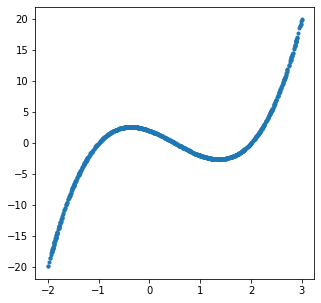

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:,0], data[:,1], marker=".")
plt.show()

# The Latent Space

Our generator is going to learn to map the uniform distribution $[0,1)$, denoted $U(0,1)$, into the space $(x,f(x))$. The following `sample_noise` function is used to obtain random noise for the generator.

In [5]:
def sample_noise(n_samples=256, low=0., high=1.):
    return np.random.uniform(low=low, high=high, size=(n_samples,1)).astype(np.float32)

# Adversarial Learning

## Models

### The Generator

Our generator network will have a single input and two outputs. The input to the network is the random noise we mapping to the data space of interested (i.e., the points $(x,f(x))$) and the output of the network is the point $(x,y)$. Our generator will consist of two fully connected hidden layers with 16 neurons each followed by leaky ReLU activation functions.

In [6]:
def create_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu, input_shape=(1,)))
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu,))
    model.add(tf.keras.layers.Dense(2))
    return model

### The Discriminator

Our discriminator network will have two inputs and a single output. The input to the network is a point $(x,y)$ and the output of the network and the output are the [logits](https://developers.google.com/machine-learning/glossary#logits). Logits are raw non-normalized predictions that classification models generate. The logits from our model can be passed to the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) to obtain the normalized prediction between 0.0 and 1.0. Our discriminator will also consist of two fully connected hidden layers with 16 neurons each followed by leaky ReLU activation functions.

In [7]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu,))
    model.add(tf.keras.layers.Dense(1))
    return model

## Loss Functions

We are going to try to train our generator to learn a distribution $p_{g}$ of the real data $x$; let $p_{data}$ represent the true distribution of the data. The generator accomplishes this by mapping the random noise from the distribution $p_{z}$ (in this case, the uniform distribution $U(0,1)$) to $p_{g}$.

Let $G\left(z;\theta_{g}\right)$ be a function that maps the random noise $z$ to the space of real data, and let $D\left(x,\theta_{d}\right)$ be a function that represents the probability that $x$ comes from the true data distribution $p_{data}$ instead of the generator's learned distrobution $p_{g}$. Here, $\theta_{g}$ and $\theta_{d}$ represent the learnable parameters (i.e., weights) of the generator and discriminator, respectively. Then, the objective function from the original GAN [paper](https://arxiv.org/pdf/1406.2661.pdf) is as follows:

$$\min_{G}\max_{D}V\left(D,G\right)=\mathbb{E}_{x\sim p_{data}\left(x\right)}\left[\log D\left(x\right)\right]+\mathbb{E}_{z\sim p_{z}\left(z\right)}\left[\log\left(1-D\left(G\left(z\right)\right)\right)\right]$$

https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

### Generator Loss

To calculate the generator's loss, we first pass random noise through the generator and then pass the generated samples to the discriminator. Since the goal of the generator is to deceive the discriminator, we want the discriminator to produce logits that correspond to 1s after the predictions are normalized (passed through the sigmoid function).

In [8]:
def generator_loss(discriminator, generator, noise, training=False):
    samples = generator(noise, training=training)
    logits = discriminator(samples, training=False)
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits,
            labels=tf.ones_like(logits)
        )
    )

### Discriminator Loss

The discriminator's loss consists of two parts. The first involves evaluating real data, while the second involves evaluating data created by the generator. When the real data is passed through the discriminator, it should produce logits that correspond to 1's; when the fake data produced by the generator is passed through the discriminator, it should produce logits that correspond to 0's.

In [9]:
def discriminator_loss(discriminator, generator, samples, noise, training=False):
    real_logits = discriminator(samples, training=training)
    fake_logits = discriminator(generator(noise, training=False))
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=real_logits,
            labels=tf.ones_like(real_logits)
        ) +
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_logits,
            labels=tf.zeros_like(fake_logits)
        )
    )

## Gradients

Here we create two helper functions to pass data through the generator and discriminator and calculate the gradients.

### Generator Gradient

In [10]:
def generator_grad(discriminator, generator, noise):
    with tf.GradientTape() as tape:
        gloss = generator_loss(discriminator, generator, noise, training=True)
    gradients = tape.gradient(gloss, generator.trainable_variables)
    return gloss, gradients

### Discriminator Gradient

In [11]:
def discriminator_grad(discriminator, generator, samples, noise):
    with tf.GradientTape() as tape:
        dloss = discriminator_loss(discriminator, generator, samples, noise, training=True)
    gradients = tape.gradient(dloss, discriminator.trainable_variables)
    return dloss, gradients

## Training Step

Here we create two helper functions to apply a single step of training. They work by calling the respective gradient functions and apply the given optimizer to the results.

### Generator Training Step

In [12]:
def generator_step(optimizer, discriminator, generator, noise):
    gloss, gradients = generator_grad(discriminator, generator, noise)
    optimizer.apply_gradients(
        zip(gradients, generator.trainable_variables)
    )
    return gloss

### Discriminator Training Step

In [13]:
def discriminator_step(optimizer, discriminator, generator, samples, noise):
    dloss, gradients = discriminator_grad(discriminator, generator, samples, noise)
    optimizer.apply_gradients(
        zip(gradients, discriminator.trainable_variables)
    )
    return dloss

# Training

The authors of the GAN paper suggest training the discriminator for several iterations followed by a single iteration of the generator for each training epoch. The following variables are used to control the training loop:
  * `n_epochs` - number of training loops
  * `batch_size` - the number of samples used in each loop of training
  * `n_discriminator_steps` - number of training steps applied to the discriminator in each epoch
  * `n_generator_steps` - number of training steps applied to the generator in each epoch

## Parameters

In [14]:
n_epochs = 10000
batch_size = 256
n_discriminator_steps = 10
n_generator_steps = 10

generator = create_generator()
discriminator = create_discriminator()
generator_optimizer = tf.optimizers.RMSprop(learning_rate=0.001)
discriminator_optimizer = tf.optimizers.RMSprop(learning_rate=0.001)

## Training Loop

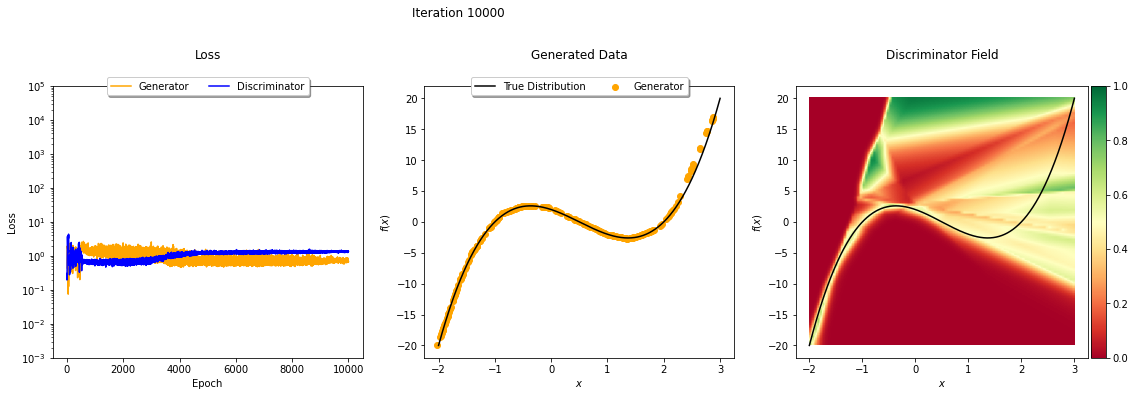

In [16]:
XX = np.linspace(data_vmin, data_vmax, 100)
YY = np.linspace(data_function(XX).min(), data_function(XX).max(), len(XX))
XX, YY = np.meshgrid(XX,YY)
POINTS = np.vstack([XX.ravel(), YY.ravel()]).T
POINTS = POINTS.astype(np.float32)

XX = np.linspace(data_vmin, data_vmax, 100000)
YY = data_function(XX)
NOISE = np.sort(sample_noise(batch_size), axis=0)
NOISE = NOISE.astype(np.float32)

discriminator_losses = list()
generator_losses = list()
for epoch in range(1,n_epochs+1):
    idx = np.random.randint(len(data), size=batch_size)
    batch_samples = data[idx,:]
    batch_noise = sample_noise(batch_size)

    for ii in range(n_discriminator_steps):
        dloss = discriminator_step(discriminator_optimizer, discriminator, generator, batch_samples, batch_noise)
    discriminator_losses.append(dloss)

    for ii in range(n_generator_steps):
        gloss = generator_step(generator_optimizer, discriminator, generator, batch_noise)
    generator_losses.append(gloss)
    
    if epoch % 100 == 0:
        sample = generator(NOISE)
        predictions = discriminator(POINTS).numpy().flatten()
        colors = np.exp(-np.logaddexp(0, -predictions))
        colors = colors.reshape(int(len(colors)**.5),-1)
        
        clear_output(wait=True)
        
        gs = mpl.gridspec.GridSpec(1,3)
        fig = plt.figure(figsize=(15,5))
        fig.suptitle("Iteration {}".format(epoch), y=1.1)
        fig.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=None)
        
        ax = fig.add_subplot(gs[0])
        ax.plot(generator_losses, color="orange", label="Generator")
        ax.plot(discriminator_losses, color="blue", label="Discriminator")
        ax.set_title("Loss", y=1.08)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_yscale("log")
        ax.set_ylim(10**-3,10**5)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=3,
            fancybox=True,
            shadow=True
        )
        
        ax = fig.add_subplot(gs[1])
        ax.plot(XX, YY, color="black", label="True Distribution", zorder=1)
        ax.scatter(
            sample[:,0],
            sample[:,1],
            color="orange",
            label="Generator",
            zorder=0
        )
        ax.set_title("Generated Data", y=1.08)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$f(x)$")
        ax.set_xlim(XX.min()-0.05*(XX.max()-XX.min()), XX.max()+0.05*(XX.max()-XX.min()))
        ax.set_ylim(YY.min()-0.05*(YY.max()-YY.min()), YY.max()+0.05*(YY.max()-YY.min()))
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=3,
            fancybox=True,
            shadow=True
        )
        
        ax = fig.add_subplot(gs[2])
        ax.plot(XX, YY, color="black", label="True Distribution", zorder=1)
        img = ax.imshow(
            colors,
            cmap="RdYlGn",
            aspect="auto",
            vmin=0.,
            vmax=1.,
            origin="lower",
            extent=[
                XX.min(), 
                XX.max(),
                YY.min(),
                YY.max()
            ],
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img, cax=cax)
        ax.set_title("Discriminator Field", y=1.08)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$f(x)$")
        ax.set_xlim(XX.min()-0.05*(XX.max()-XX.min()), XX.max()+0.05*(XX.max()-XX.min()))
        ax.set_ylim(YY.min()-0.05*(YY.max()-YY.min()), YY.max()+0.05*(YY.max()-YY.min()))
        ax.set_aspect("auto")
        
        plt.show()